In [1]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json \
    -O /tmp/sarcasm.json

--2022-01-18 17:37:09--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.141.128, 173.194.210.128, 173.194.212.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.141.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5643545 (5.4M) [application/json]
Saving to: ‘/tmp/sarcasm.json’

/tmp/sarcasm.json   100%[===================>]   5.38M  --.-KB/s    in 0.03s   

2022-01-18 17:37:09 (188 MB/s) - ‘/tmp/sarcasm.json’ saved [5643545/5643545]



In [2]:
import tensorflow as tf
import numpy as np
import json
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [48]:
with open("/tmp/sarcasm.json", "r") as file:
  datastore = json.load(file)

sentences = []
labels = []

for item in datastore:
  sentences.append(item["headline"])
  labels.append(item["is_sarcastic"])

len(sentences)

JSONDecodeError: ignored

In [49]:
training_size = int(len(sentences) * 0.8)
training_sentences = sentences[:training_size]
test_sentences = sentences[training_size:]


training_labels = labels[:training_size]
test_labels = labels[training_size:]

len(training_labels), len(test_labels), len(training_sentences), len(test_sentences)

(21367, 5342, 21367, 5342)

In [76]:
vocab_size = 2000
oov_token = "<OOV>"

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_token)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.index_word

training_sequence = tokenizer.texts_to_sequences(training_sentences)
train_padded_seq = pad_sequences(training_sequence, 
                                 maxlen=100, 
                                 padding="post", 
                                 truncating="post")

test_sequence = tokenizer.texts_to_sequences(test_sentences)
test_padded_seq = pad_sequences(test_sequence, 
                                padding="post", 
                                truncating="post",
                                maxlen=100)

In [77]:
test_padded_seq = np.array(test_padded_seq)
train_padded_seq = np.array(train_padded_seq)

test_labels = np.array(test_labels)
training_labels = np.array(training_labels)

In [78]:
input = tf.keras.layers.Input(shape=(100,), name="input_shape")
x = tf.keras.layers.Embedding(vocab_size, output_dim=16, input_length=100)(input)
x = tf.keras.layers.GlobalAveragePooling1D()(x)
x = tf.keras.layers.Dense(24, activation="relu")(x)
# x = tf.keras.layers.Dense(128, activation="relu")(x)
output = tf.keras.layers.Dense(1, activation="sigmoid")(x)

model = tf.keras.Model(input, output)

model.compile(loss="binary_crossentropy",
              optimizer="Adam",
              metrics=["accuracy"])

history = model.fit(train_padded_seq, training_labels,
          validation_data=(test_padded_seq, test_labels),
          # batch_size=32,
          epochs=30)

Epoch 1/30
668/668 [==============================] - 2s 3ms/step - loss: 0.6652 - accuracy: 0.5812 - val_loss: 0.5786 - val_accuracy: 0.6864
Epoch 2/30
668/668 [==============================] - 2s 3ms/step - loss: 0.4532 - accuracy: 0.8036 - val_loss: 0.4066 - val_accuracy: 0.8192
Epoch 3/30
668/668 [==============================] - 2s 3ms/step - loss: 0.3660 - accuracy: 0.8406 - val_loss: 0.3806 - val_accuracy: 0.8323
Epoch 4/30
668/668 [==============================] - 2s 3ms/step - loss: 0.3382 - accuracy: 0.8544 - val_loss: 0.3794 - val_accuracy: 0.8315
Epoch 5/30
668/668 [==============================] - 2s 3ms/step - loss: 0.3235 - accuracy: 0.8602 - val_loss: 0.3721 - val_accuracy: 0.8340
Epoch 6/30
668/668 [==============================] - 2s 2ms/step - loss: 0.3154 - accuracy: 0.8636 - val_loss: 0.3740 - val_accuracy: 0.8317
Epoch 7/30
668/668 [==============================] - 2s 3ms/step - loss: 0.3070 - accuracy: 0.8662 - val_loss: 0.3810 - val_accuracy: 0.8360
Epoch 

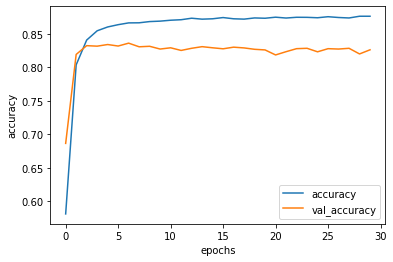

In [79]:
import matplotlib.pyplot as plt

def plot_curve (history, key): 
  plt.plot(history.history[key])
  plt.plot(history.history[f"val_{key}"])
  plt.xlabel("epochs")
  plt.ylabel(key)
  plt.legend([key, f"val_{key}"])
  plt.show()

plot_curve(history, "accuracy")
plot_curve(history, "loss")

In [80]:

def decode_sentence(seq):
  return " ".join([word_index.get(i, "?") for i in seq])


print(decode_sentence(test_padded_seq[0]))
print(test_sentences[0])
print(model.predict(np.expand_dims(test_padded_seq[0], axis=0)))
print(test_labels[0])

report <OOV> of <OOV> sexual <OOV> <OOV> to <OOV> ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ?
report: 98% of german sexual intercourse uploaded to pornhub
[[0.9601742]]
1


In [81]:
_sentence = ["granny starting to fear spiders in the garden might be real", 
            "game of thrones season finale showing this sunday night"]

_sentence_seq = tokenizer.texts_to_sequences(_sentence)
_sentence_padded_seq = pad_sequences(_sentence_seq, maxlen=100, padding="post", truncating="post")

print(model.predict(_sentence_padded_seq))

[[0.4116436 ]
 [0.04832047]]
